In [1]:
%matplotlib inline

# Preprocessing and Spike Sorting Tutorial

# Chapter 1: Importing Recording Data and Metadata

In [2]:
import os
import warnings
import glob
import pickle
import _pickle as cPickle
import imp
import git
import copy

/tmp/ipykernel_406745/2531468151.py:6: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp


In [3]:
from collections import defaultdict
import time
import json

In [4]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import numpy as np
import pandas as pd
import scipy.signal

In [5]:
from probeinterface import get_probe
from probeinterface.plotting import plot_probe, plot_probe_group
from probeinterface import write_prb, read_prb

In [6]:
# Changing the figure size
from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=80)

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

The spikeinterface module by itself import only the spikeinterface.core submodule
which is not useful for end user



In [7]:
import spikeinterface

We need to import one by one different submodules separately (preferred).
There are 5 modules:

- :code:`extractors` : file IO
- :code:`toolkit` : processing toolkit for pre-, post-processing, validation, and automatic curation
- :code:`sorters` : Python wrappers of spike sorters
- :code:`comparison` : comparison of spike sorting output
- :code:`widgets` : visualization



In [8]:
import spikeinterface as si  # import core only
import spikeinterface.extractors as se
import spikeinterface.sorters as ss
import spikeinterface.comparison as sc
import spikeinterface.widgets as sw

In [9]:
import spikeinterface.core

We can also import all submodules at once with this
  this internally import core+extractors+toolkit+sorters+comparison+widgets+exporters

This is useful for notebooks but this is a more heavy import because internally many more dependency
are imported (scipy/sklearn/networkx/matplotlib/h5py...)



In [10]:
import spikeinterface.full as si

In [11]:
# Increase size of plot in jupyter

plt.rcParams["figure.figsize"] = (10,6)

# Part 1: Importing Data

## Loading in the Electrophysiology Recording

- Getting the root directory of the Github Repo to base the files off of

In [12]:
git_repo = git.Repo(".", search_parent_directories=True)
git_root = git_repo.git.rev_parse("--show-toplevel")

In [13]:
git_root

'/nancy/projects/reward_competition_extention'

- Getting a list of all the electrophysiological recording files
    - **NOTE**: If your recording file does not end with `.rec` or is in a different directory than `./data` then you must change `glob.glob({./path/to/recording_file.rec})` below. Where you replace `{./path/to/recording_file.rec}` with the path to your recording file without the brackets.

In [14]:
recording_filepath_glob = "/scratch/back_up/reward_competition_extention/data/omission/2023_06_18/20230618_100636_standard_comp_to_omission_D2_subj_1-4_and_1-1.rec/*merged*.rec"

In [15]:
recording_absolultepath_glob = os.path.join(git_root, recording_filepath_glob)

In [16]:
# Getting all the file paths of the recording files(that happen to all end in `.rec`)
all_recording_files = glob.glob(recording_absolultepath_glob, recursive=True)
# Checking to see if the file is an actual file
all_recording_files = [path for path in all_recording_files if os.path.isfile(path)]
# Checking to see if the file is the correct size
all_recording_files = [path for path in all_recording_files if os.path.getsize(path) > 10 ** 6]



In [17]:
all_recording_files

['/scratch/back_up/reward_competition_extention/data/omission/2023_06_18/20230618_100636_standard_comp_to_omission_D2_subj_1-4_and_1-1.rec/20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged.rec',
 '/scratch/back_up/reward_competition_extention/data/omission/2023_06_18/20230618_100636_standard_comp_to_omission_D2_subj_1-4_and_1-1.rec/20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged.rec']

In [18]:
len(all_recording_files)

2

## Reading in a Probe file

In [19]:
probe_filepath_glob = "data/*.prb"

In [20]:
probe_absolultepath_glob = os.path.join(git_root, probe_filepath_glob)

In [21]:
# Getting all the file paths of the recording parameter files(that happen to all end in `.prm`)
all_probe_files = glob.glob(probe_absolultepath_glob, recursive=True)

In [22]:
all_probe_files

['/nancy/projects/reward_competition_extention/data/linear_probe_with_large_spaces.prb']

- If you have more than one metadata file, then you must either:
    - A. Put the index of the file in `all_parameter_files[0]` below. You would replace the `0` with the correct index. (Remember, Python is zero indexed so the first file in the list is 0. Second is 1, and so forth.
    - B. Add a absolute or relative path to `open({./path/to/recording_file.rec})` below. You would replace `{./path/to/recording_file.rec}` with the path of the file for the metadata.

In [23]:
if len(all_probe_files) < 1:
    warnings.warn("There are no parameter files in the directory that you specified. Please add a file, or correct the directory path")
else:
    probe_parameters = imp.load_source("probe_parameters", all_probe_files[0])
    with open(all_probe_files[0]) as info_file:
        lines = info_file.readlines()
        for line in lines:
            print(line)

channel_groups = {0: {'channels': [0,

                  1,

                  2,

                  3,

                  4,

                  5,

                  6,

                  7,

                  8,

                  9,

                  10,

                  11,

                  12,

                  13,

                  14,

                  15,

                  16,

                  17,

                  18,

                  19,

                  20,

                  21,

                  22,

                  23,

                  24,

                  25,

                  26,

                  27,

                  28,

                  29,

                  30,

                  31],

     'geometry':{

    0: (0, 0),

    1: (5, 20),

    2: (-7, 40),

    3: (9, 60),

    4: (-11, 80),

    5: (13, 100),

    6: (-15, 120),

    7: (17, 140),

    8: (-19, 160),

    9: (21, 180),

    10: (-23, 200),

    11: (25, 220),

    12: (-27

- Reading in the probe information into Spike interface and plotting the probe

In [24]:
if len(all_probe_files) < 1:
    warnings.warn("There are no parameter files in the directory that you specified. Please add a file, or correct the directory path")
else:
    # Reading in the probe data
    probe_object = read_prb(all_probe_files[0])

In [25]:
probe_object.to_dataframe()

,probe_index,x,y,contact_shapes,radius,shank_ids,contact_ids
0,0,0.0,0.0,circle,5.0,,
1,0,5.0,20.0,circle,5.0,,
2,0,-7.0,40.0,circle,5.0,,
3,0,9.0,60.0,circle,5.0,,
4,0,-11.0,80.0,circle,5.0,,
5,0,13.0,100.0,circle,5.0,,
6,0,-15.0,120.0,circle,5.0,,
7,0,17.0,140.0,circle,5.0,,
8,0,-19.0,160.0,circle,5.0,,
9,0,21.0,180.0,circle,5.0,,


In [26]:
probe_object.get_global_contact_ids()

array(['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',
       '', '', '', '', '', '', '', '', '', '', '', '', '', '', ''],
      dtype='<U64')

In [27]:
probe_object.get_global_device_channel_indices()

array([(0,  0), (0,  1), (0,  2), (0,  3), (0,  4), (0,  5), (0,  6),
       (0,  7), (0,  8), (0,  9), (0, 10), (0, 11), (0, 12), (0, 13),
       (0, 14), (0, 15), (0, 16), (0, 17), (0, 18), (0, 19), (0, 20),
       (0, 21), (0, 22), (0, 23), (0, 24), (0, 25), (0, 26), (0, 27),
       (0, 28), (0, 29), (0, 30), (0, 31)],
      dtype=[('probe_index', '<i8'), ('device_channel_indices', '<i8')])

- Creating a dictionary of all the variables in the probe file

In [28]:
if 'probe_parameters' in locals():
    probe_dict = defaultdict(dict)
    for attribute in dir(probe_parameters):
        # Removing built in attributes
        if not attribute.startswith("__"): 
            probe_dict[attribute] = getattr(probe_parameters, attribute)

In [29]:
if "probe_dict" in locals():
    for key, value in probe_dict.items():
        print("{}: {}".format(key, value))

channel_groups: {0: {'channels': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31], 'geometry': {0: (0, 0), 1: (5, 20), 2: (-7, 40), 3: (9, 60), 4: (-11, 80), 5: (13, 100), 6: (-15, 120), 7: (17, 140), 8: (-19, 160), 9: (21, 180), 10: (-23, 200), 11: (25, 220), 12: (-27, 240), 13: (29, 260), 14: (-31, 280), 15: (33, 300), 16: (-35, 320), 17: (37, 340), 18: (-39, 360), 19: (41, 380), 20: (-43, 400), 21: (45, 420), 22: (-47, 440), 23: (49, 460), 24: (-51, 480), 25: (53, 500), 26: (-55, 520), 27: (57, 540), 28: (-59, 560), 29: (61, 580), 30: (-63, 600), 31: (65, 620)}, 'graph': [(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9), (9, 10), (10, 11), (11, 12), (12, 13), (13, 14), (14, 15), (15, 16), (16, 17), (17, 18), (18, 19), (19, 20), (20, 21), (21, 22), (22, 23), (23, 24), (24, 25), (25, 26), (26, 27), (27, 28), (28, 29), (29, 30), (30, 31)]}}


## Reading in all recording files into Spikeinterface

- Iterating through all the files and saving them to file

In [30]:
# Best channels with current setup
channel_ids = ["13", "14", "15", "16", "21"]

- Maybe only look at relevant brain region channels
- And save to drive

In [31]:
all_recording_files

['/scratch/back_up/reward_competition_extention/data/omission/2023_06_18/20230618_100636_standard_comp_to_omission_D2_subj_1-4_and_1-1.rec/20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged.rec',
 '/scratch/back_up/reward_competition_extention/data/omission/2023_06_18/20230618_100636_standard_comp_to_omission_D2_subj_1-4_and_1-1.rec/20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged.rec']

20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
Channel ids: ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9' '10' '11' '12' '13' '14' '15'
 '16' '17' '18' '19' '20' '21' '22' '23' '24' '25' '26' '27' '28' '29'
 '30' '31']
Sampling frequency: 20000.0
Number of channels: 32
Number of segments: 1
Duration: 68592695
Number of hours: 0.9526763194444445
Parent output directory: ./proc/20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
Channel ids: ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9' '10' '11' '12' '13' '14' '15'
 '16' '17' '18' '19' '20' '21' '22' '23' '24' '25' '26' '27' '28' '29'
 '30' '31']
Sampling frequency: 20000.0
Number of channels: 32
Number of segments: 1
Duration: 65603030
Number of hours: 0.9111531944444444
Parent output directory: ./proc/20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged


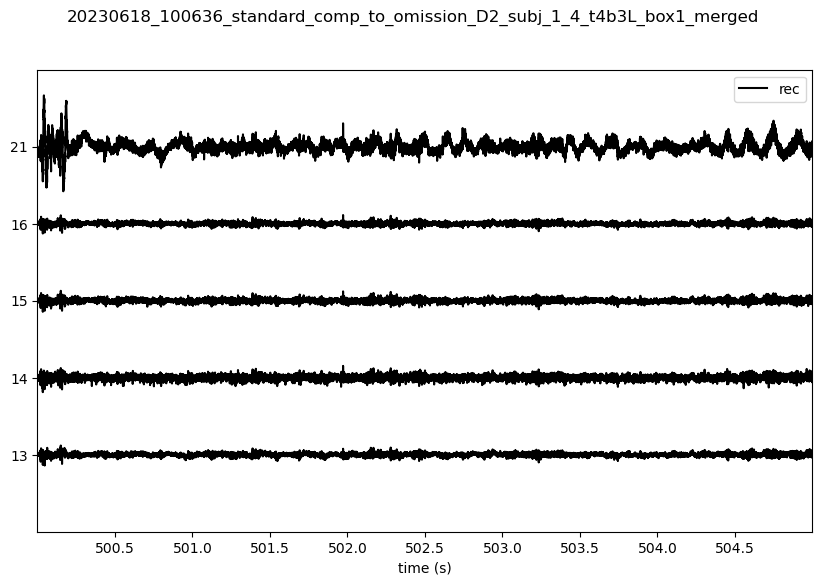

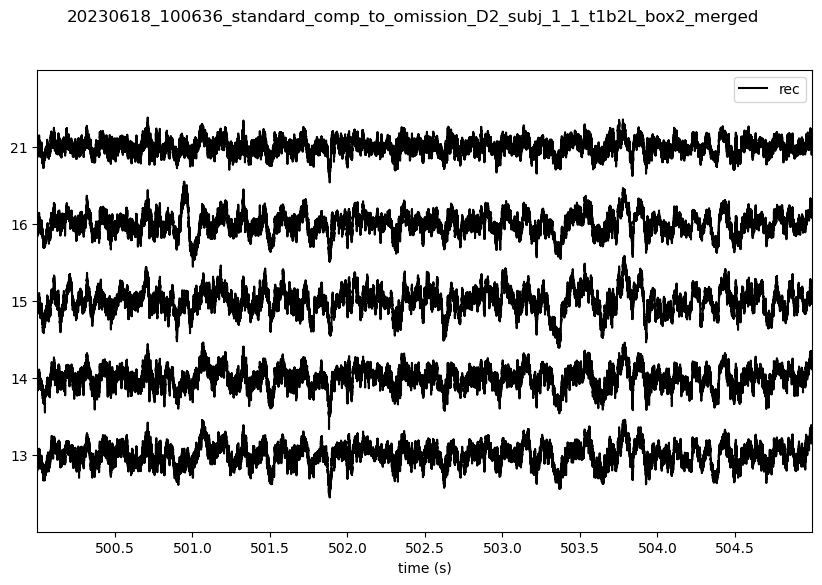

In [32]:
files_with_issues = []
time_series_to_recording = defaultdict(dict)
for recording_path in all_recording_files:
    try:
        ### Getting the file root
        recording_file_name = os.path.basename(recording_path)
        recording_file_root = os.path.splitext(recording_file_name)[0]
        print(recording_file_root)

        ### Making an output directory
        parent_output_directory = "./proc/{}".format(recording_file_root)
        os.makedirs(parent_output_directory, exist_ok=True)

        ### Reading in the ephys recording
        trodes_recording = se.read_spikegadgets(recording_path, stream_id="trodes")
        trodes_recording = trodes_recording.set_probes(probe_object)

        ### Showing the metadata
        fs = trodes_recording.get_sampling_frequency()
        num_chan = trodes_recording.get_num_channels()
        num_seg = trodes_recording.get_num_segments()
        duration = trodes_recording.get_num_frames()

        print('Channel ids:', trodes_recording.get_channel_ids())
        print('Sampling frequency:', fs)
        print('Number of channels:', num_chan)
        print('Number of segments:', num_seg)
        print('Duration:', duration)
        print('Number of hours:', duration/fs/3600)

        w_ts = sw.plot_timeseries(trodes_recording, time_range=(500, 505), channel_ids=channel_ids, show_channel_ids=True)
        w_ts.figure.suptitle(recording_file_root)
        
        time_series_filename = "{}_example_time_series.png".format(recording_file_root)
        w_ts.figure.savefig(os.path.join(parent_output_directory, time_series_filename))   
        
        time_series_to_recording[time_series_filename]["parent_output_directory"] = parent_output_directory
        print("Parent output directory: {}".format(parent_output_directory))
        time_series_to_recording[time_series_filename]["recording_file_name"] = recording_file_name
        time_series_to_recording[time_series_filename]["recording_path"] = recording_path
    except:
        continue



In [33]:
time_series_to_recording

defaultdict(dict,
            {'20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged_example_time_series.png': {'parent_output_directory': './proc/20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged',
              'recording_file_name': '20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged.rec',
              'recording_path': '/scratch/back_up/reward_competition_extention/data/omission/2023_06_18/20230618_100636_standard_comp_to_omission_D2_subj_1-4_and_1-1.rec/20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged.rec'},
             '20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged_example_time_series.png': {'parent_output_directory': './proc/20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged',
              'recording_file_name': '20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged.rec',
              'recording_path': '/scratch/back_up/reward_

In [34]:
files_with_issues

[]

### Getting a list of all the recordings I want to use

- Categorized all the time series image based on their quality. Will only process all the good recordings.

In [35]:
resampled_frequency = 1000

In [36]:
recordings_with_issues = []
for recording_path in all_recording_files:
    try:
        ### Getting the file root
        recording_file_name = os.path.basename(recording_path)
        recording_file_root = os.path.splitext(recording_file_name)[0]
        print("Recording Path: {}".format(recording_path))
    #         print(os.path.isfile(recording_path))
        parent_output_directory = "./proc/{}".format(recording_file_root)

        ### Reading in the recording
        trodes_recording = se.read_spikegadgets(recording_path, stream_id="trodes")

        ### Preprocessing the recording
        preprocessing_step_dict = defaultdict(dict)
        preprocessing_step_dict["recording_raw"] = trodes_recording

        recording_intermediate = copy.copy(trodes_recording)
        # Bandpass Filtering, keeping all the points that are within a certain frequency range
        recording_bandpass = spikeinterface.preprocessing.bandpass_filter(recording_intermediate, freq_min=0.5, freq_max=300)
        recording_intermediate = spikeinterface.preprocessing.bandpass_filter(recording_intermediate, freq_min=0.5, freq_max=300)
        preprocessing_step_dict["recording_bandpass"] = recording_bandpass
        print(recording_bandpass)
        
        # Notch Filtering, keeping all the points that are within a certain frequency range
        recording_notch = spikeinterface.preprocessing.notch_filter(recording_intermediate, freq=60)
        recording_intermediate = spikeinterface.preprocessing.notch_filter(recording_intermediate, freq=60)
        preprocessing_step_dict["recording_notch"] = recording_notch
        print(recording_bandpass)

        # We are not going to run the resampling step because it causes issues with saving to file
        # Resampling
        recording_resample = spikeinterface.preprocessing.resample(recording_intermediate, resample_rate=resampled_frequency)
        preprocessing_step_dict["recording_resample"] = recording_resample
        print(recording_resample)
        
        try:
            time_range = (500, 505)
            for key, value in preprocessing_step_dict.items():
                preprocessed_timeseries_plot = sw.plot_timeseries(value, time_range=(time_range[0], time_range[1]), channel_ids=channel_ids, show_channel_ids=True) #, figure=fig)
                plt.title("{} on {} step beginning".format(recording_file_root, key))
                plt.ylabel("Channels")
                fig_file_name = "{}_{}_beginning".format(key, recording_file_root)
                plt.savefig(os.path.join(parent_output_directory, fig_file_name))
                plt.close()
        except Exception as e: 
            print(e)
            
        try:
            time_range = (2500, 2505)
            for key, value in preprocessing_step_dict.items():
                preprocessed_timeseries_plot = sw.plot_timeseries(value, time_range=(time_range[0], time_range[1]), channel_ids=channel_ids, show_channel_ids=True) #, figure=fig)
                plt.title("{} on {} step ending".format(recording_file_root, key))
                plt.ylabel("Channels")
                fig_file_name = "{}_{}_ending".format(key, recording_file_root)
                plt.savefig(os.path.join(parent_output_directory, fig_file_name))
                plt.close()
        except Exception as e: 
            print(e)            
            
        preprocessing_output_directory = os.path.join(parent_output_directory, "lfp_preprocessing")
        recording_intermediate.save_to_folder(name="lfp_preprocessing", folder=preprocessing_output_directory, n_jobs=8)
    except Exception as e: 
        print(e)
        recordings_with_issues.append(recording_path)


Recording Path: /scratch/back_up/reward_competition_extention/data/omission/2023_06_18/20230618_100636_standard_comp_to_omission_D2_subj_1-4_and_1-1.rec/20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged.rec
BandpassFilterRecording: 32 channels - 1 segments - 20.0kHz - 3429.635s
BandpassFilterRecording: 32 channels - 1 segments - 20.0kHz - 3429.635s
ResampleRecording: 32 channels - 1 segments - 1.0kHz - 3429.634s
write_binary_recording with n_jobs = 8 and chunk_size = 20000


write_binary_recording:   0%|          | 0/3430 [00:00<?, ?it/s]

Recording Path: /scratch/back_up/reward_competition_extention/data/omission/2023_06_18/20230618_100636_standard_comp_to_omission_D2_subj_1-4_and_1-1.rec/20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged.rec
BandpassFilterRecording: 32 channels - 1 segments - 20.0kHz - 3280.151s
BandpassFilterRecording: 32 channels - 1 segments - 20.0kHz - 3280.151s
ResampleRecording: 32 channels - 1 segments - 1.0kHz - 3280.151s
write_binary_recording with n_jobs = 8 and chunk_size = 20000


write_binary_recording:   0%|          | 0/3281 [00:00<?, ?it/s]

./proc/20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged/lfp_preprocessing
./proc/20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged/lfp_preprocessing


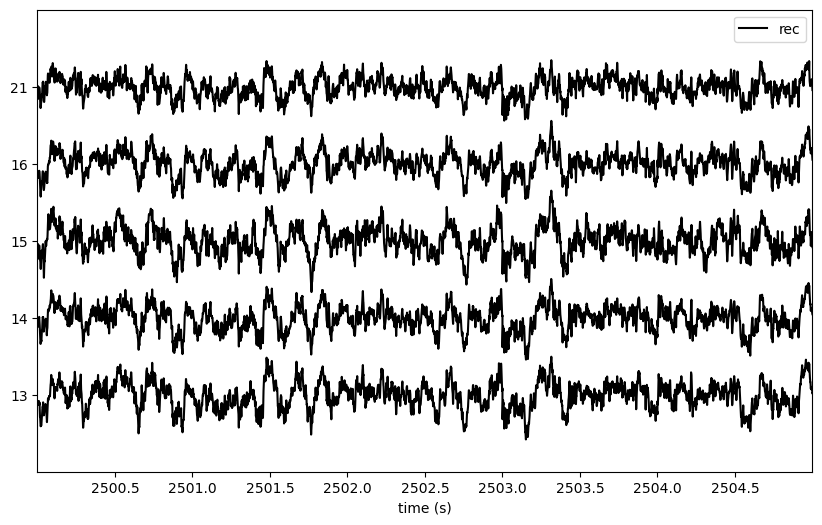

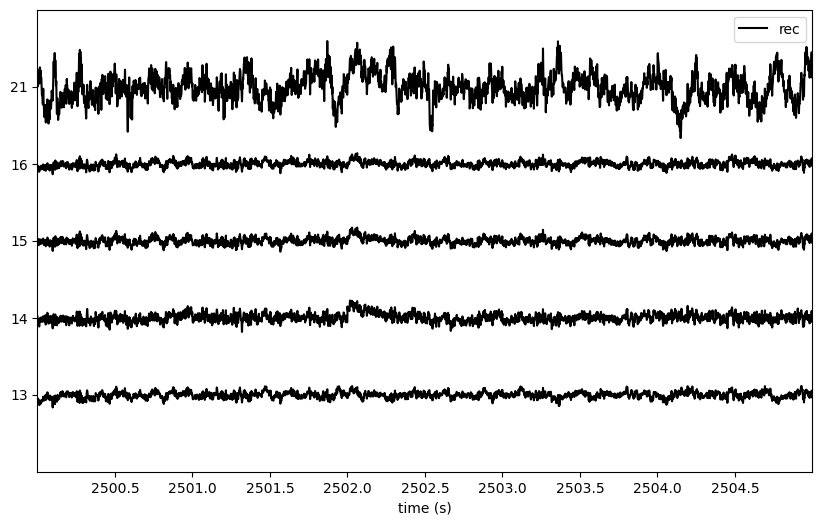

In [37]:
for processing_folder in glob.glob("./proc/*/lfp_preprocessing"):
    try:
        recording_test = spikeinterface.core.load_extractor(file_or_folder_or_dict=processing_folder)
        sw.plot_timeseries(recording_test, time_range=time_range, channel_ids=channel_ids, show_channel_ids=True)
        print(processing_folder)
    except:
        continue